In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from utils import *

c:\Downloads\[2025] Khóa luận\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_excel('../dtset.xlsx', sheet_name='filled_data')
df.head()

,bank,quarterly,year,time,NPL,IR,GDP,IIP,INF,CPI,UN,M2,PCR,LTA,ROA,ROE,LDR
0,ABB,1,2012,2012q1,0.0325,0.138700,0.0464,0.0650,0.08,0.1415,0.0222,0.142546,0.0160,0.499451,0.00740,0.065500,0.705935
1,ABB,2,2012,2012q2,0.0325,0.113667,0.0480,0.0802,0.05,0.0690,0.0218,0.142546,0.0153,0.399700,0.00639,0.072606,0.547300
2,ABB,3,2012,2012q3,0.0325,0.092067,0.0505,0.0965,0.04,0.0648,0.0229,0.142546,0.0160,0.499451,0.00740,0.065500,0.705935
3,ABB,4,2012,2012q4,0.0290,0.093667,0.0544,0.0593,0.04,0.0681,0.0212,0.142546,0.0221,0.398600,0.00910,0.083000,0.504700
4,ABB,1,2013,2013q1,0.0325,0.090000,0.0476,0.0516,0.04,0.0664,0.0227,0.142546,0.0221,0.407600,0.00880,0.083000,1.614000


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1173 entries, 0 to 1172
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   bank       1173 non-null   object 
 1   quarterly  1173 non-null   int64  
 2   year       1173 non-null   int64  
 3   time       1173 non-null   object 
 4   NPL        1173 non-null   float64
 5   IR         1173 non-null   float64
 6   GDP        1173 non-null   float64
 7   IIP        1173 non-null   float64
 8   INF        1173 non-null   float64
 9   CPI        1173 non-null   float64
 10  UN         1173 non-null   float64
 11  M2         1173 non-null   float64
 12  PCR        1173 non-null   float64
 13  LTA        1173 non-null   float64
 14  ROA        1173 non-null   float64
 15  ROE        1173 non-null   float64
 16  LDR        1173 non-null   float64
dtypes: float64(13), int64(2), object(2)
memory usage: 155.9+ KB


In [4]:
zero_counts = (df == 0).sum()
nan_counts = df.isna().sum()

checking = pd.DataFrame({
    "Cột": df.columns,
    "Số giá trị NaN": nan_counts.values,
    "Số giá trị 0": zero_counts.values
})

checking

,Cột,Số giá trị NaN,Số giá trị 0
0,bank,0,0
1,quarterly,0,0
2,year,0,0
3,time,0,0
4,NPL,0,0
5,IR,0,0
6,GDP,0,0
7,IIP,0,0
8,INF,0,0
9,CPI,0,0


In [5]:
df['time'] = pd.to_datetime(df['year'].astype(str) + '-' + (df['quarterly'] * 3).astype(str) + '-01')
df.set_index(['bank', 'time'], inplace=True)

df.head()

quarterly  year     NPL        IR     GDP     IIP   INF  \
bank time                                                                  
ABB  2012-03-01          1  2012  0.0325  0.138700  0.0464  0.0650  0.08   
     2012-06-01          2  2012  0.0325  0.113667  0.0480  0.0802  0.05   
     2012-09-01          3  2012  0.0325  0.092067  0.0505  0.0965  0.04   
     2012-12-01          4  2012  0.0290  0.093667  0.0544  0.0593  0.04   
     2013-03-01          1  2013  0.0325  0.090000  0.0476  0.0516  0.04   

                    CPI      UN        M2     PCR       LTA      ROA  \
bank time                                                              
ABB  2012-03-01  0.1415  0.0222  0.142546  0.0160  0.499451  0.00740   
     2012-06-01  0.0690  0.0218  0.142546  0.0153  0.399700  0.00639   
     2012-09-01  0.0648  0.0229  0.142546  0.0160  0.499451  0.00740   
     2012-12-01  0.0681  0.0212  0.142546  0.0221  0.398600  0.00910   
     2013-03-01  0.0664  0.0227  0.142546  0.0221  0.407600  0.00880   

                      ROE       LDR  
bank time                            
ABB  2012-03-01  0.065500  0.705935  
     2012-06-01  0.072606  0.547300  
     2012-09-01  0.065500  0.705935  
     2012-12-01  0.083000  0.504700  
     2013-03-01  0.083000  1.614000

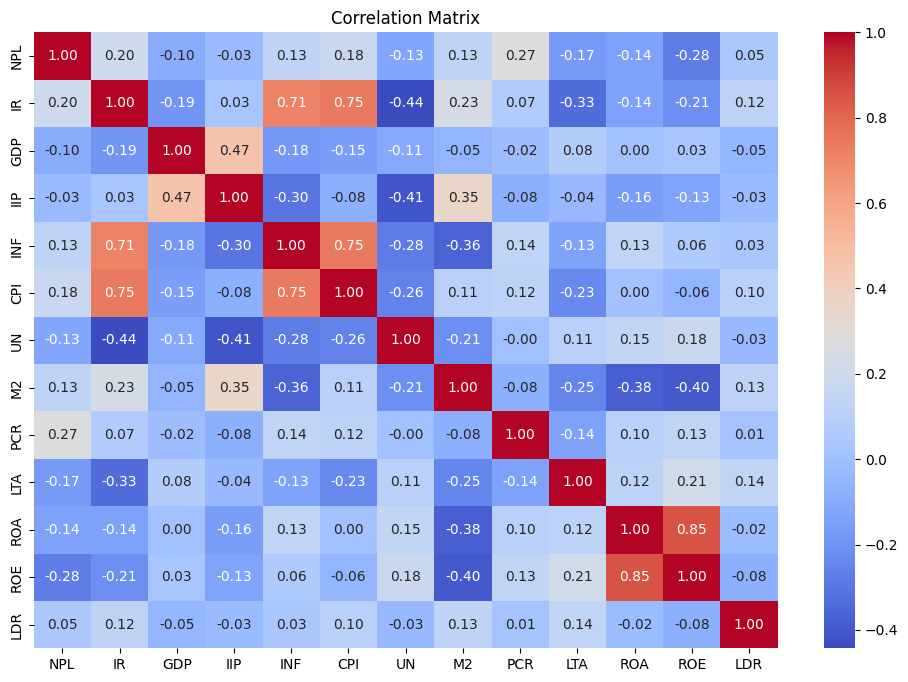

In [6]:
df_numeric = df.drop(columns=['year', 'quarterly', 'time'], errors='ignore')

corr_matrix = df_numeric.corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix")
plt.show()

In [7]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

X = df[['IR', 'GDP', 'IIP', 'INF', 'CPI', 'UN', 'M2', 'PCR', 'LTA', 'ROA', 'ROE', 'LDR']] 

# Ađ intercept to compute VIF
X = add_constant(X)

vif_df = pd.DataFrame()
vif_df["Variable"] = X.columns
vif_df["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

vif_df

,Variable,VIF
0,const,356.567209
1,IR,5.416406
2,GDP,1.436502
3,IIP,2.201373
4,INF,10.158238
5,CPI,3.925190
6,UN,1.774722
7,M2,3.850929
8,PCR,1.074833
9,LTA,1.307843


In [8]:
df = df.drop(columns=['CPI', 'ROE'], errors='ignore')

df.head()

quarterly  year     NPL        IR     GDP     IIP   INF  \
bank time                                                                  
ABB  2012-03-01          1  2012  0.0325  0.138700  0.0464  0.0650  0.08   
     2012-06-01          2  2012  0.0325  0.113667  0.0480  0.0802  0.05   
     2012-09-01          3  2012  0.0325  0.092067  0.0505  0.0965  0.04   
     2012-12-01          4  2012  0.0290  0.093667  0.0544  0.0593  0.04   
     2013-03-01          1  2013  0.0325  0.090000  0.0476  0.0516  0.04   

                     UN        M2     PCR       LTA      ROA       LDR  
bank time                                                               
ABB  2012-03-01  0.0222  0.142546  0.0160  0.499451  0.00740  0.705935  
     2012-06-01  0.0218  0.142546  0.0153  0.399700  0.00639  0.547300  
     2012-09-01  0.0229  0.142546  0.0160  0.499451  0.00740  0.705935  
     2012-12-01  0.0212  0.142546  0.0221  0.398600  0.00910  0.504700  
     2013-03-01  0.0227  0.142546  0.0221  0.407600  0.00880  1.614000

### Train - Test

In [9]:
df.reset_index(inplace=True)
df = df.sort_values(by="time")

split_date = pd.to_datetime("2022-04-01")  # Q2/2022

train_df = df[df['time'] < split_date]
test_df = df[df['time'] >= split_date]

print(f"Train size: {train_df.shape}, Test size: {test_df.shape}")

Train size: (943, 15), Test size: (230, 15)


In [10]:
train_df.head()

,bank,time,quarterly,year,NPL,IR,GDP,IIP,INF,UN,M2,PCR,LTA,ROA,LDR
0,ABB,2012-03-01,1,2012,0.0325,0.1387,0.0464,0.065,0.08,0.0222,0.142546,0.0160,0.499451,0.0074,0.705935
561,OCB,2012-03-01,1,2012,0.0236,0.1387,0.0464,0.065,0.08,0.0222,0.142546,0.0107,0.574200,0.0134,0.808600
714,SHB,2012-03-01,1,2012,0.0247,0.1387,0.0464,0.065,0.08,0.0222,0.142546,0.0134,0.418700,0.0120,0.480400
1020,VCB,2012-03-01,1,2012,0.0295,0.1387,0.0464,0.065,0.08,0.0222,0.142546,0.0286,0.563500,0.0117,0.848200
153,BID,2012-03-01,1,2012,0.0299,0.1387,0.0464,0.065,0.08,0.0222,0.142546,0.0171,0.723400,0.0072,0.902700


In [11]:
test_df.head()

,bank,time,quarterly,year,NPL,IR,GDP,IIP,INF,UN,M2,PCR,LTA,ROA,LDR
41,ABB,2022-06-01,2,2022,0.0233,0.02589,0.0772,0.091,0.0198,0.0232,0.0997,0.0121,0.5896,0.0157,0.6894
194,BID,2022-06-01,2,2022,0.0106,0.02589,0.0772,0.091,0.0198,0.0232,0.0997,0.0268,0.7292,0.0071,0.8703
653,PGB,2022-06-01,2,2022,0.0270,0.02589,0.0772,0.091,0.0198,0.0232,0.0997,0.0099,0.6562,0.0082,0.7664
806,SSB,2022-06-01,2,2022,0.0163,0.02589,0.0772,0.091,0.0198,0.0232,0.0997,0.0153,0.6292,0.0166,0.7981
1163,VPB,2022-06-01,2,2022,0.0543,0.02589,0.0772,0.091,0.0198,0.0232,0.0997,0.0326,0.6243,0.0305,0.9470


In [12]:
def determine_differencing_order(series):
    """
    Determine the minimum differencing order (0, 1, or 2) required to make the time series stationary
    using the Augmented Dickey-Fuller (ADF) test.
    """
    p_val = adfuller(series.dropna())[1]
    if p_val <= 0.05:
        return 0
    p_val = adfuller(series.diff().dropna())[1]
    if p_val <= 0.05:
        return 1
    p_val = adfuller(series.diff().diff().dropna())[1]
    if p_val <= 0.05:
        return 2
    return -1  # Not stationary even after second-order differencing

In [13]:
def run_arima_forecasting(train_df, test_df, order_pq=(1, 1)):
    """
    Run ARIMA forecasting per bank using pre-split train and test datasets.
    
    Parameters:
        train_df: DataFrame containing training data (with 'bank', 'time', 'NPL')
        test_df: DataFrame containing testing data (same structure as train_df)
        order_pq: tuple (p, q) for ARIMA model
    
    Returns:
        arima_results: dict of fitted models per bank
        eval_results: list of evaluation results per bank
    """
    arima_results = {}
    eval_results = []

    banks = train_df['bank'].unique()
    train_df = train_df.set_index(['bank', 'time'])
    test_df = test_df.set_index(['bank', 'time'])

    for bank in banks:
        print(f"\n📈 Bank: {bank}")

        train = train_df.loc[bank]['NPL']
        test = test_df.loc[bank]['NPL']
        steps = len(test)

        d = determine_differencing_order(train)
        if d == -1:
            print("⚠️ Unable to determine differencing order (d ≤ 2)")
            continue

        try:
            model = ARIMA(train, order=(order_pq[0], d, order_pq[1]))
            fit = model.fit()
            preds = fit.forecast(steps=steps)
        except Exception as e:
            print(f"❌ ARIMA failed for {bank}: {e}")
            continue

        # Evaluation and plotting
        eval_res = evaluate(test, preds, "ARIMA", bank)
        plot_results(test, preds, "ARIMA", bank)

        arima_results[bank] = fit
        eval_results.append(eval_res)

    return arima_results, eval_results


📈 Bank: ABB
ARIMA - ABB | MAE: 0.0102, MSE: 0.0002, RMSE: 0.0124, R²: -2.0781, SMAPE: 33.33%, MASE: 1.5957

c:\Downloads\[2025] Khóa luận\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
c:\Downloads\[2025] Khóa luận\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
c:\Downloads\[2025] Khóa luận\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


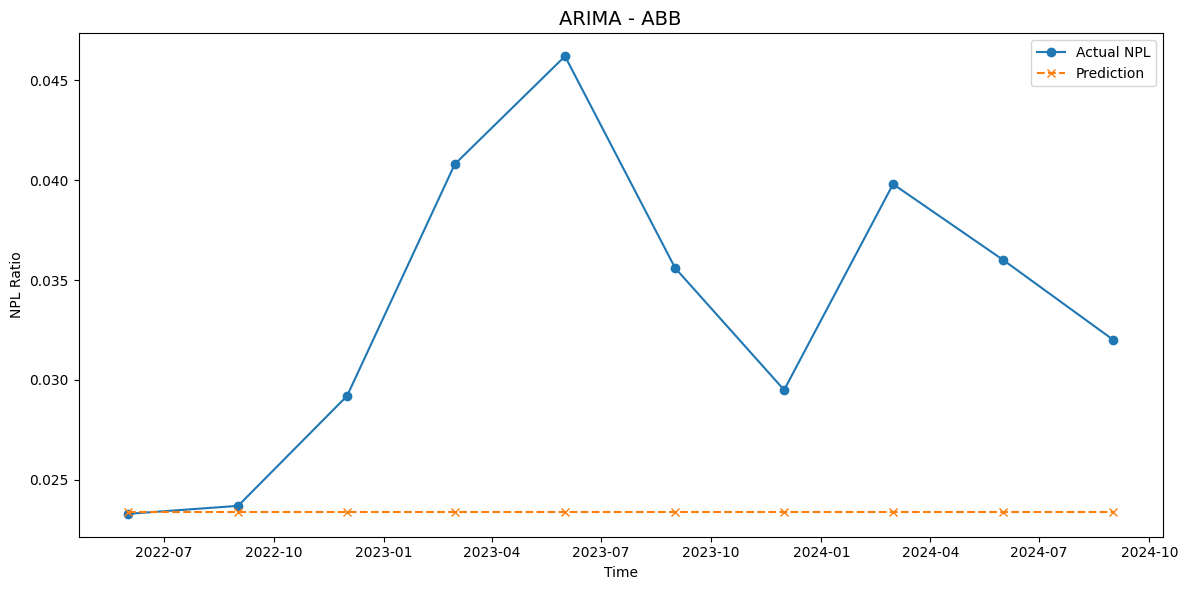


📈 Bank: OCB
ARIMA - OCB | MAE: 0.0079, MSE: 0.0001, RMSE: 0.0092, R²: -2.0784, SMAPE: 29.49%, MASE: 1.7021


c:\Downloads\[2025] Khóa luận\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
c:\Downloads\[2025] Khóa luận\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
c:\Downloads\[2025] Khóa luận\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


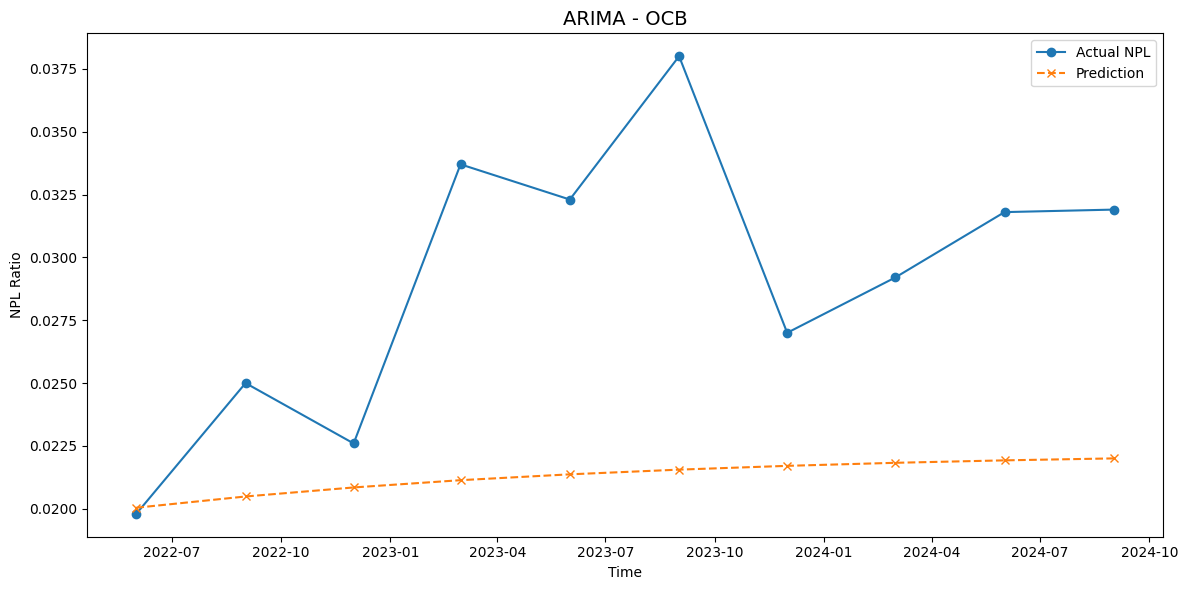


📈 Bank: SHB
ARIMA - SHB | MAE: 0.0017, MSE: 0.0000, RMSE: 0.0023, R²: 0.2195, SMAPE: 6.33%, MASE: 1.1722


c:\Downloads\[2025] Khóa luận\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
c:\Downloads\[2025] Khóa luận\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
c:\Downloads\[2025] Khóa luận\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


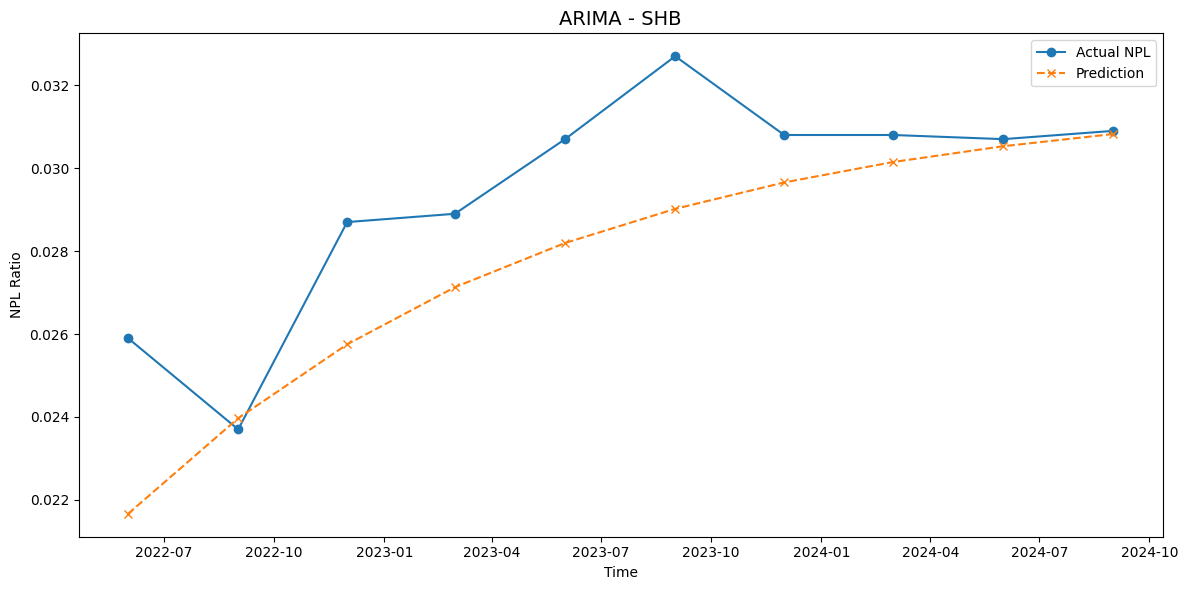


📈 Bank: VCB
ARIMA - VCB | MAE: 0.0038, MSE: 0.0000, RMSE: 0.0047, R²: -3.2092, SMAPE: 44.49%, MASE: 2.4201


c:\Downloads\[2025] Khóa luận\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
c:\Downloads\[2025] Khóa luận\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
c:\Downloads\[2025] Khóa luận\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
c:\Downloads\[2025] Khóa luận\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


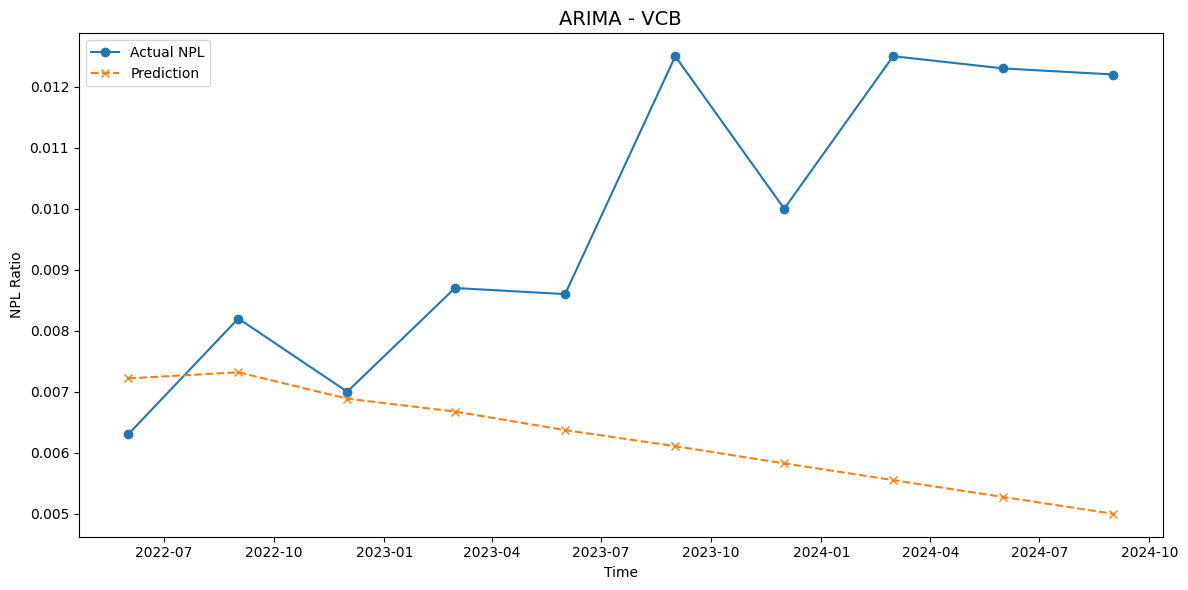


📈 Bank: BID
ARIMA - BID | MAE: 0.0047, MSE: 0.0000, RMSE: 0.0051, R²: -5.2137, SMAPE: 37.08%, MASE: 2.4120


c:\Downloads\[2025] Khóa luận\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
c:\Downloads\[2025] Khóa luận\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
c:\Downloads\[2025] Khóa luận\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


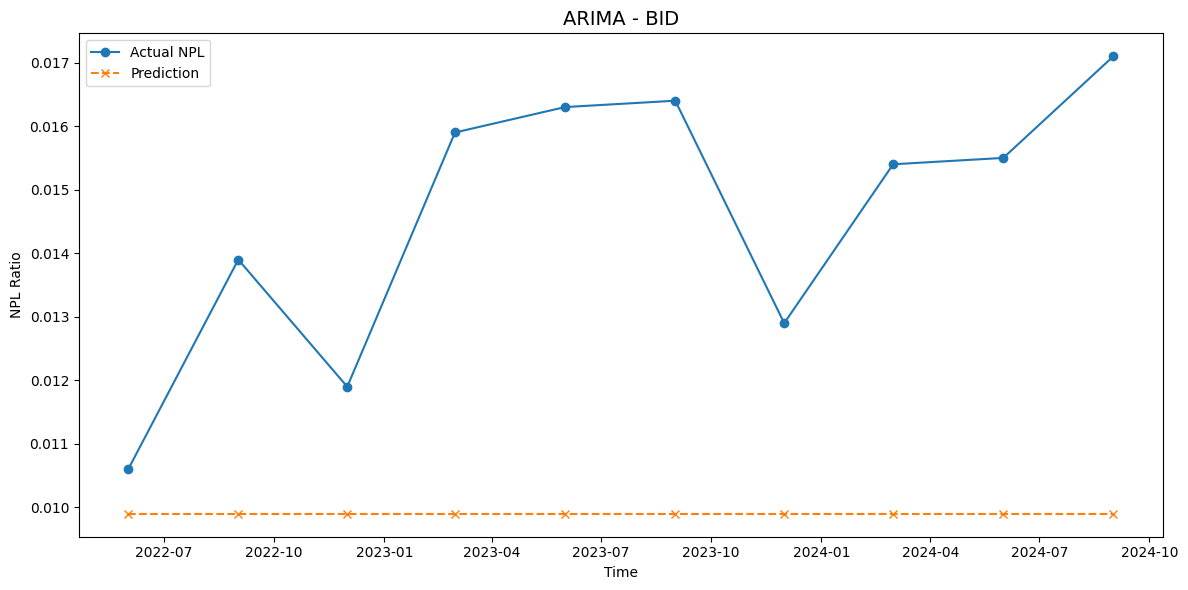


📈 Bank: VPB
ARIMA - VPB | MAE: 0.0064, MSE: 0.0001, RMSE: 0.0085, R²: -0.9781, SMAPE: 11.50%, MASE: 1.3675


c:\Downloads\[2025] Khóa luận\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
c:\Downloads\[2025] Khóa luận\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
c:\Downloads\[2025] Khóa luận\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


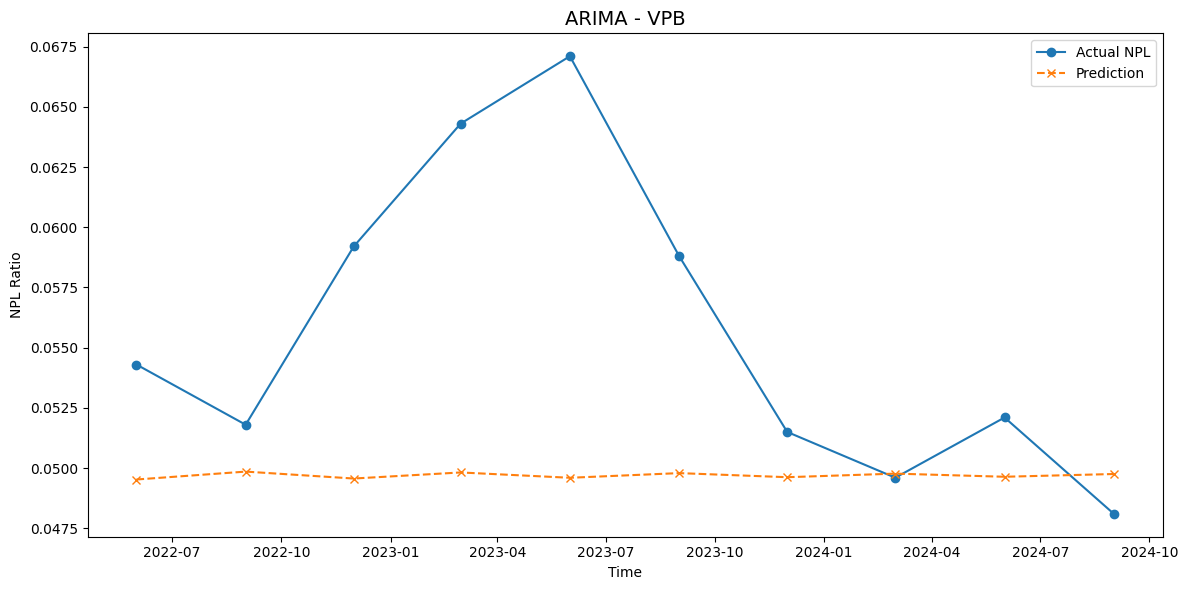


📈 Bank: MBB
ARIMA - MBB | MAE: 0.0037, MSE: 0.0000, RMSE: 0.0043, R²: -1.1227, SMAPE: 20.34%, MASE: 1.4933


c:\Downloads\[2025] Khóa luận\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
c:\Downloads\[2025] Khóa luận\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
c:\Downloads\[2025] Khóa luận\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


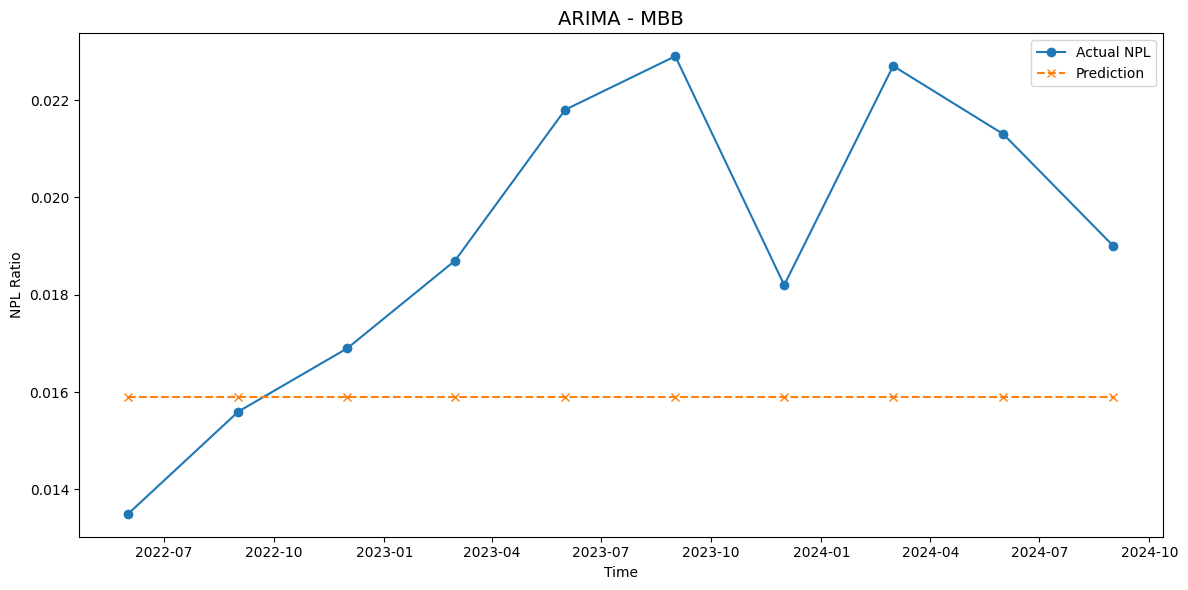


📈 Bank: SSB
ARIMA - SSB | MAE: 0.0017, MSE: 0.0000, RMSE: 0.0021, R²: -1.0067, SMAPE: 9.42%, MASE: 3.0124


c:\Downloads\[2025] Khóa luận\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
c:\Downloads\[2025] Khóa luận\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
c:\Downloads\[2025] Khóa luận\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


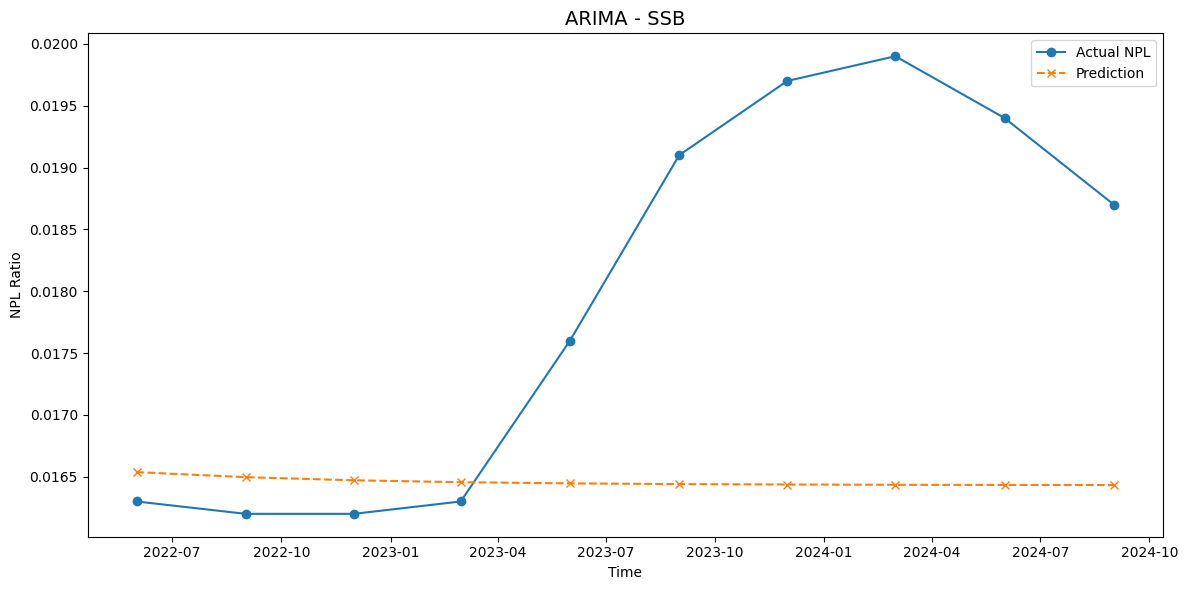


📈 Bank: BAB
ARIMA - BAB | MAE: 0.0048, MSE: 0.0000, RMSE: 0.0055, R²: -1.9774, SMAPE: 47.44%, MASE: 3.2533


c:\Downloads\[2025] Khóa luận\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
c:\Downloads\[2025] Khóa luận\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
c:\Downloads\[2025] Khóa luận\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


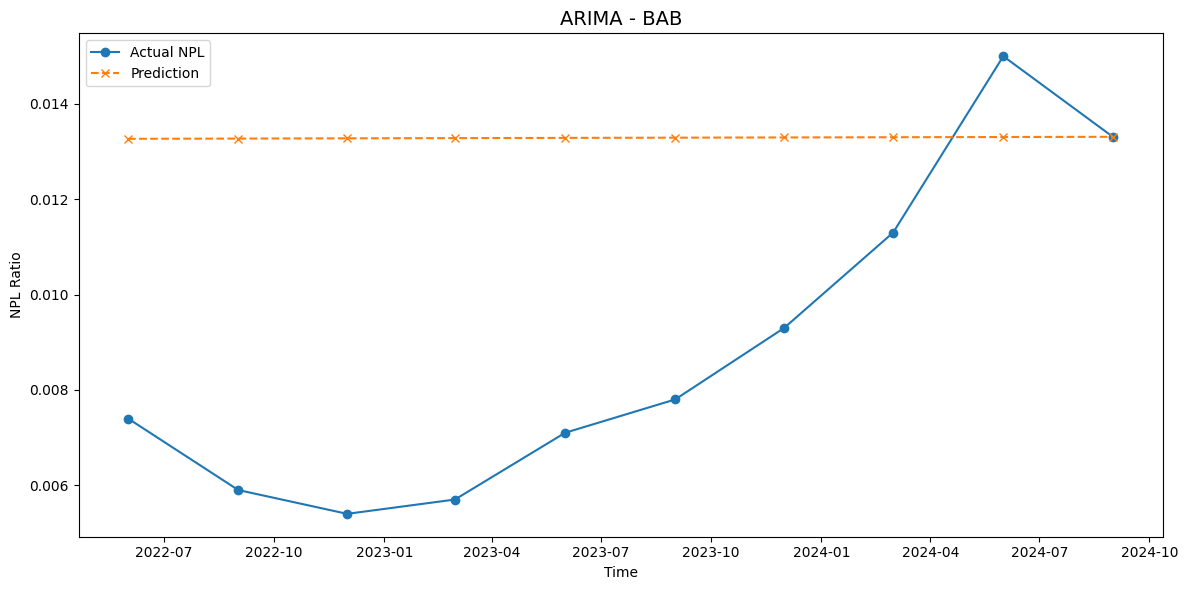


📈 Bank: VIB
ARIMA - VIB | MAE: 0.0089, MSE: 0.0001, RMSE: 0.0106, R²: -2.3801, SMAPE: 29.52%, MASE: 3.0301


c:\Downloads\[2025] Khóa luận\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
c:\Downloads\[2025] Khóa luận\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
c:\Downloads\[2025] Khóa luận\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


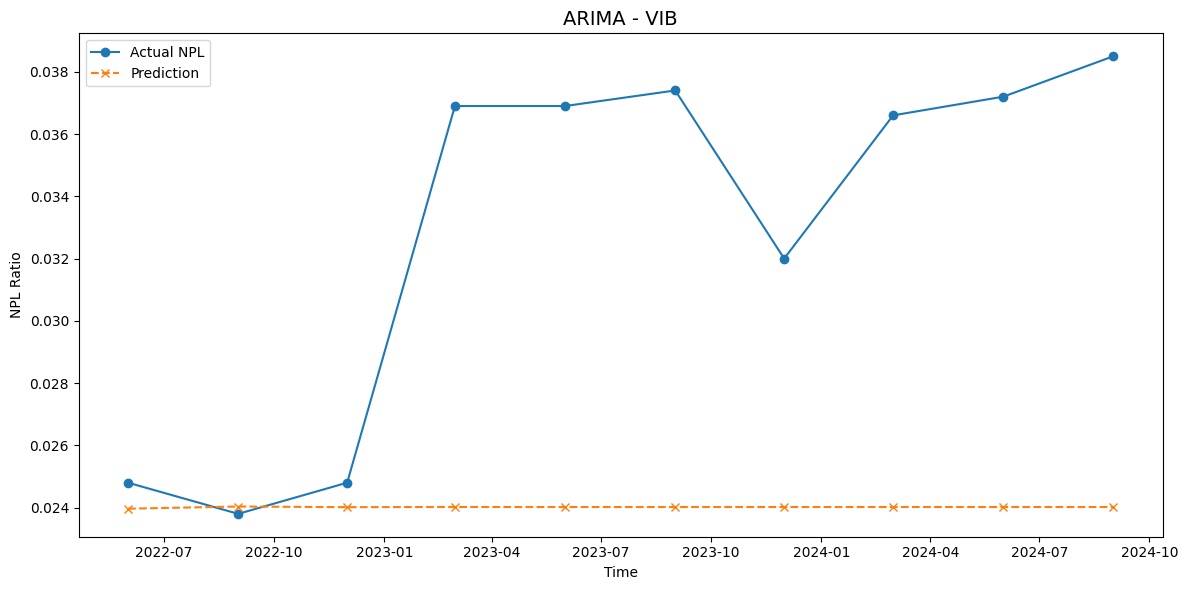


📈 Bank: VBB
ARIMA - VBB | MAE: 0.0073, MSE: 0.0001, RMSE: 0.0091, R²: -1.8326, SMAPE: 19.07%, MASE: 1.3284


c:\Downloads\[2025] Khóa luận\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
c:\Downloads\[2025] Khóa luận\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
c:\Downloads\[2025] Khóa luận\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


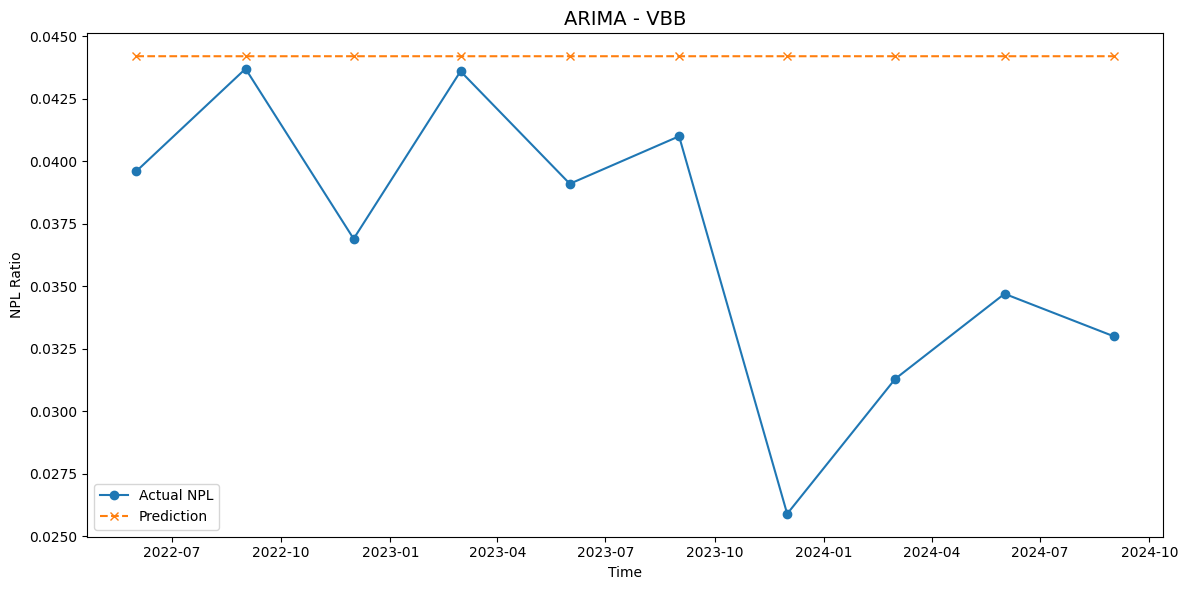


📈 Bank: PGB
ARIMA - PGB | MAE: 0.0036, MSE: 0.0000, RMSE: 0.0048, R²: -1.2110, SMAPE: 12.85%, MASE: 0.9917


c:\Downloads\[2025] Khóa luận\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
c:\Downloads\[2025] Khóa luận\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
c:\Downloads\[2025] Khóa luận\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


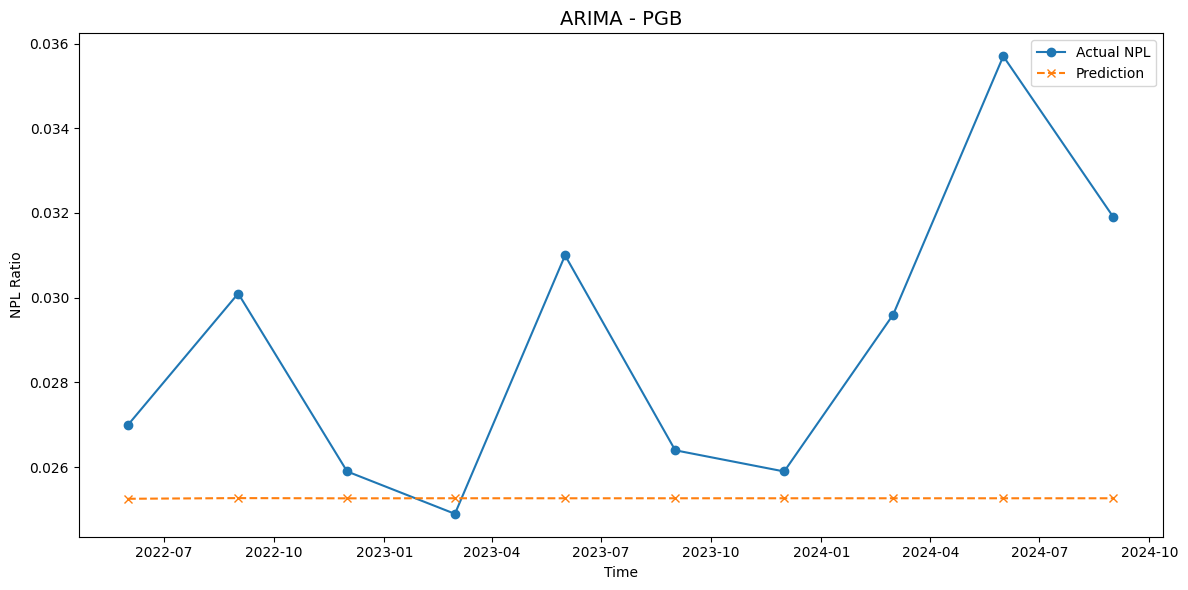


📈 Bank: CTG
ARIMA - CTG | MAE: 0.0009, MSE: 0.0000, RMSE: 0.0012, R²: -0.0785, SMAPE: 6.81%, MASE: 0.6595


c:\Downloads\[2025] Khóa luận\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
c:\Downloads\[2025] Khóa luận\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
c:\Downloads\[2025] Khóa luận\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


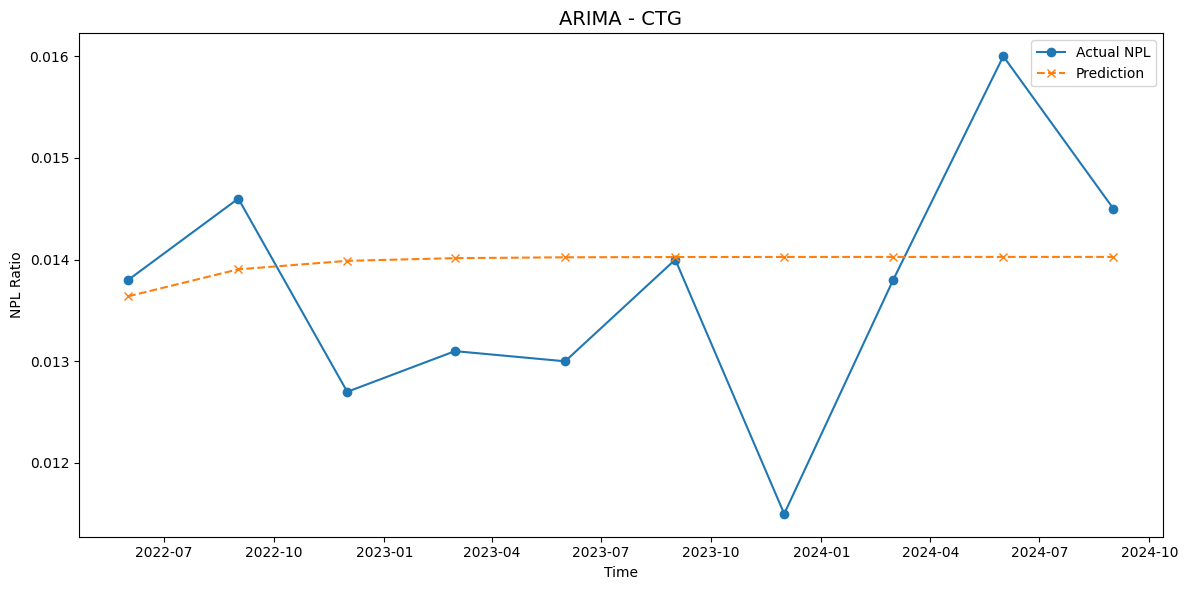


📈 Bank: SGB
ARIMA - SGB | MAE: 0.0037, MSE: 0.0000, RMSE: 0.0041, R²: -1.5793, SMAPE: 15.36%, MASE: 2.0757


c:\Downloads\[2025] Khóa luận\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
c:\Downloads\[2025] Khóa luận\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
c:\Downloads\[2025] Khóa luận\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


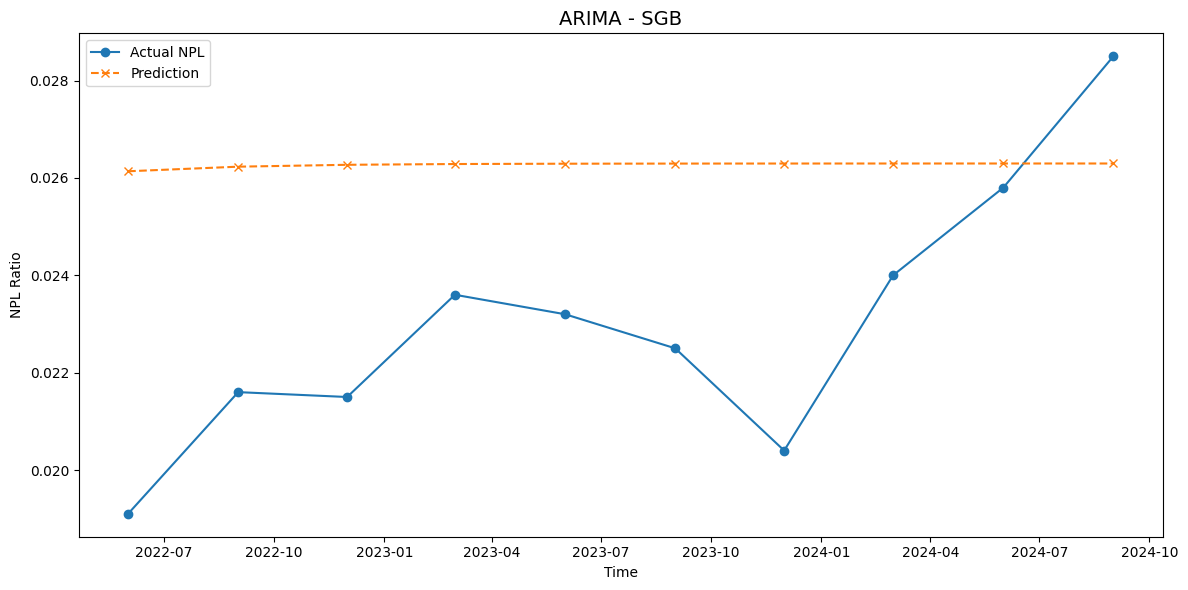


📈 Bank: TPB
ARIMA - TPB | MAE: 0.0068, MSE: 0.0001, RMSE: 0.0076, R²: -0.1710, SMAPE: 40.80%, MASE: 1.6034


c:\Downloads\[2025] Khóa luận\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
c:\Downloads\[2025] Khóa luận\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
c:\Downloads\[2025] Khóa luận\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


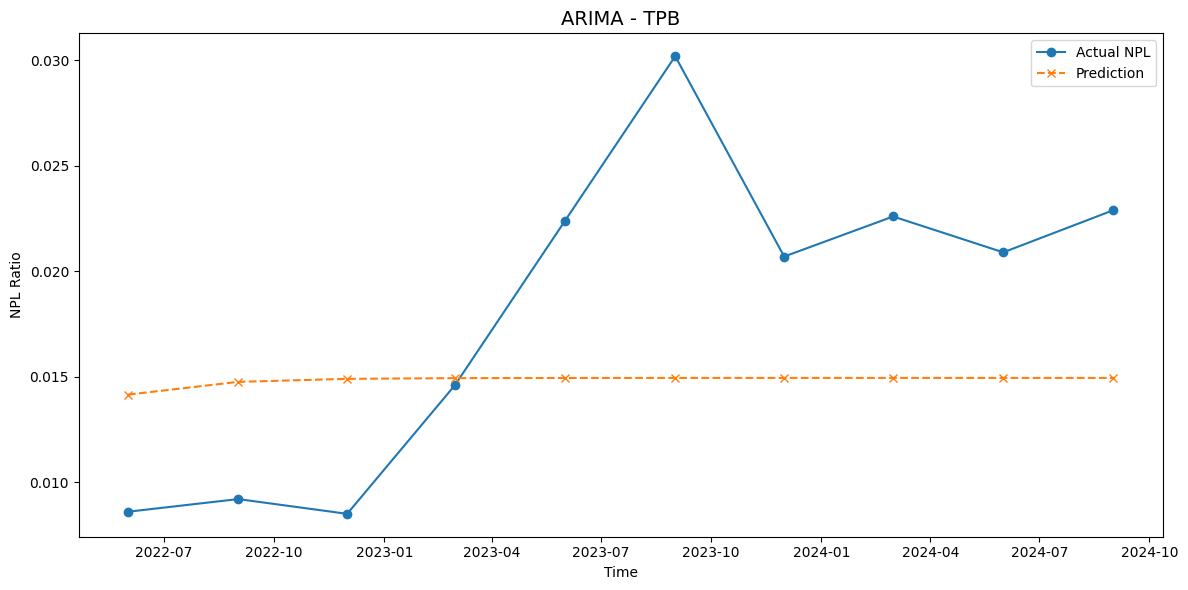


📈 Bank: EIB
ARIMA - EIB | MAE: 0.0038, MSE: 0.0000, RMSE: 0.0041, R²: -0.1049, SMAPE: 16.11%, MASE: 2.0705


c:\Downloads\[2025] Khóa luận\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
c:\Downloads\[2025] Khóa luận\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
c:\Downloads\[2025] Khóa luận\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


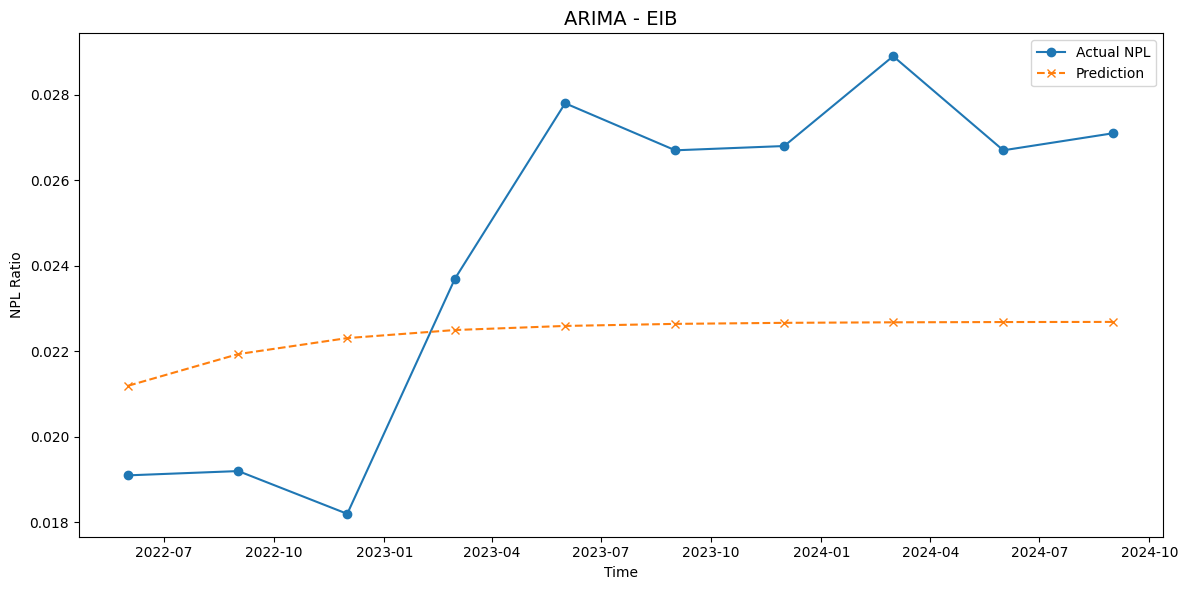


📈 Bank: NAB
ARIMA - NAB | MAE: 0.0065, MSE: 0.0001, RMSE: 0.0073, R²: -0.7927, SMAPE: 30.86%, MASE: 1.2952


c:\Downloads\[2025] Khóa luận\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
c:\Downloads\[2025] Khóa luận\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
c:\Downloads\[2025] Khóa luận\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


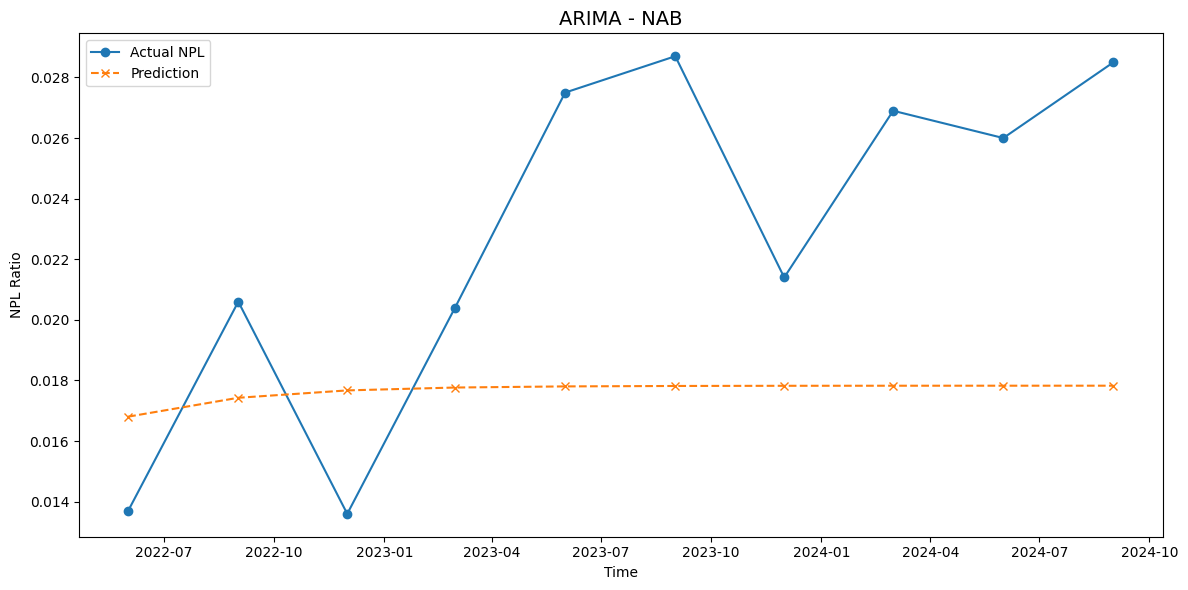


📈 Bank: KLB
ARIMA - KLB | MAE: 0.0021, MSE: 0.0000, RMSE: 0.0024, R²: -0.3671, SMAPE: 10.04%, MASE: 0.8764


c:\Downloads\[2025] Khóa luận\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
c:\Downloads\[2025] Khóa luận\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
c:\Downloads\[2025] Khóa luận\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


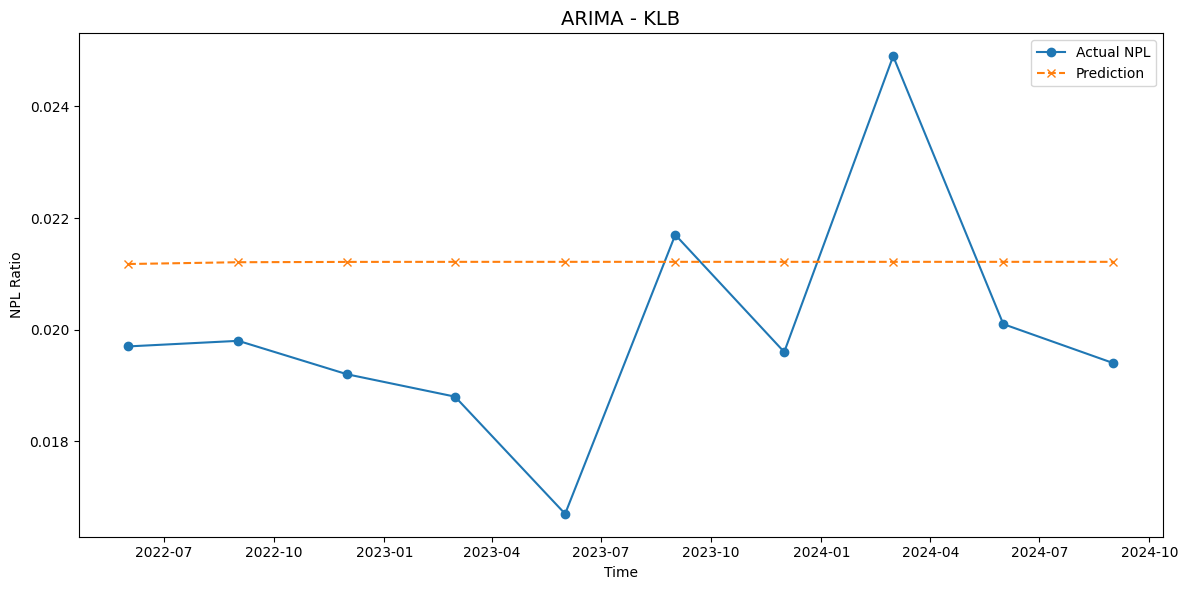


📈 Bank: STB
ARIMA - STB | MAE: 0.0064, MSE: 0.0001, RMSE: 0.0073, R²: -0.4477, SMAPE: 37.99%, MASE: 2.9608


c:\Downloads\[2025] Khóa luận\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
c:\Downloads\[2025] Khóa luận\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
c:\Downloads\[2025] Khóa luận\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


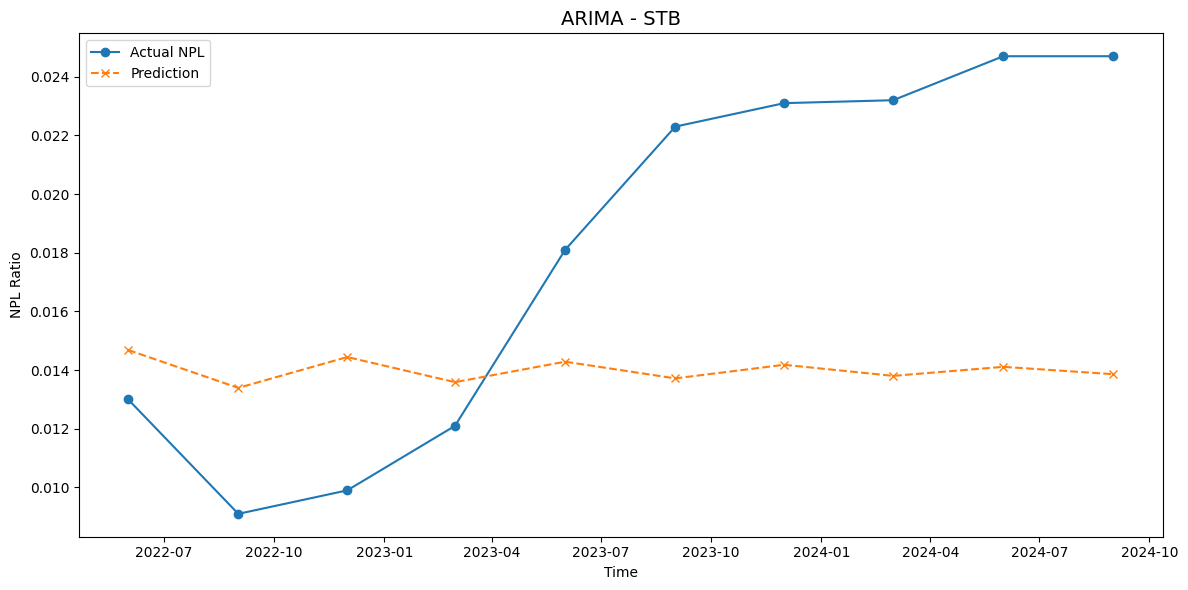


📈 Bank: TCB
ARIMA - TCB | MAE: 0.0061, MSE: 0.0001, RMSE: 0.0071, R²: -6.9900, SMAPE: 79.55%, MASE: 4.2903


c:\Downloads\[2025] Khóa luận\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
c:\Downloads\[2025] Khóa luận\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
c:\Downloads\[2025] Khóa luận\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


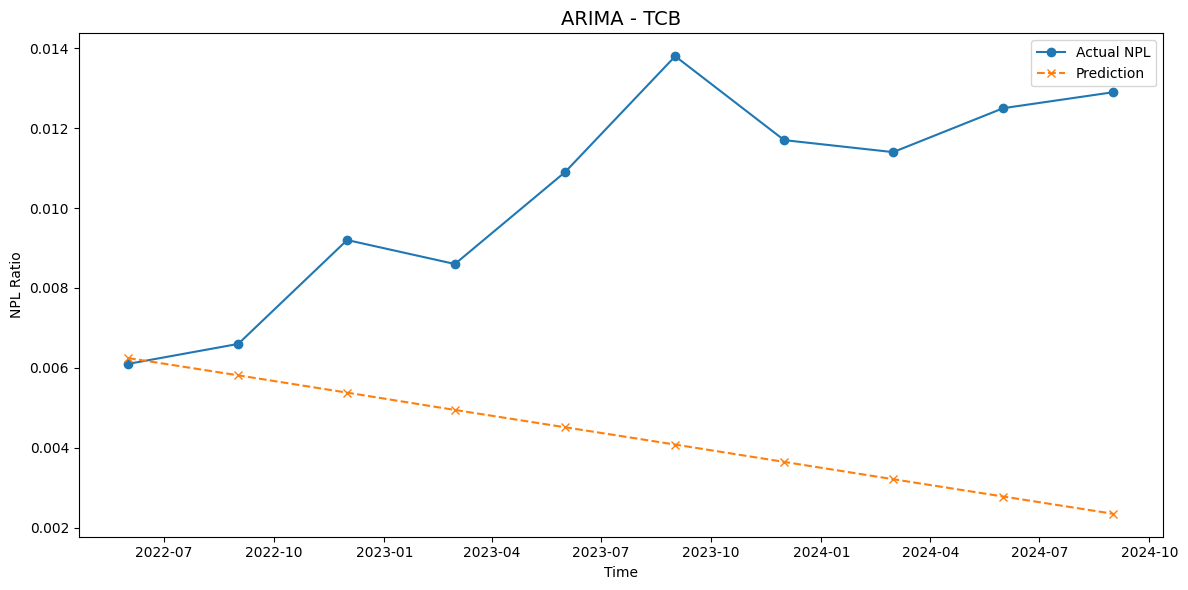


📈 Bank: HDB


c:\Downloads\[2025] Khóa luận\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
c:\Downloads\[2025] Khóa luận\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
c:\Downloads\[2025] Khóa luận\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
c:\Downloads\[2025] Khóa luận\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA - HDB | MAE: 0.0073, MSE: 0.0001, RMSE: 0.0085, R²: -2.4737, SMAPE: 52.03%, MASE: 1.5209


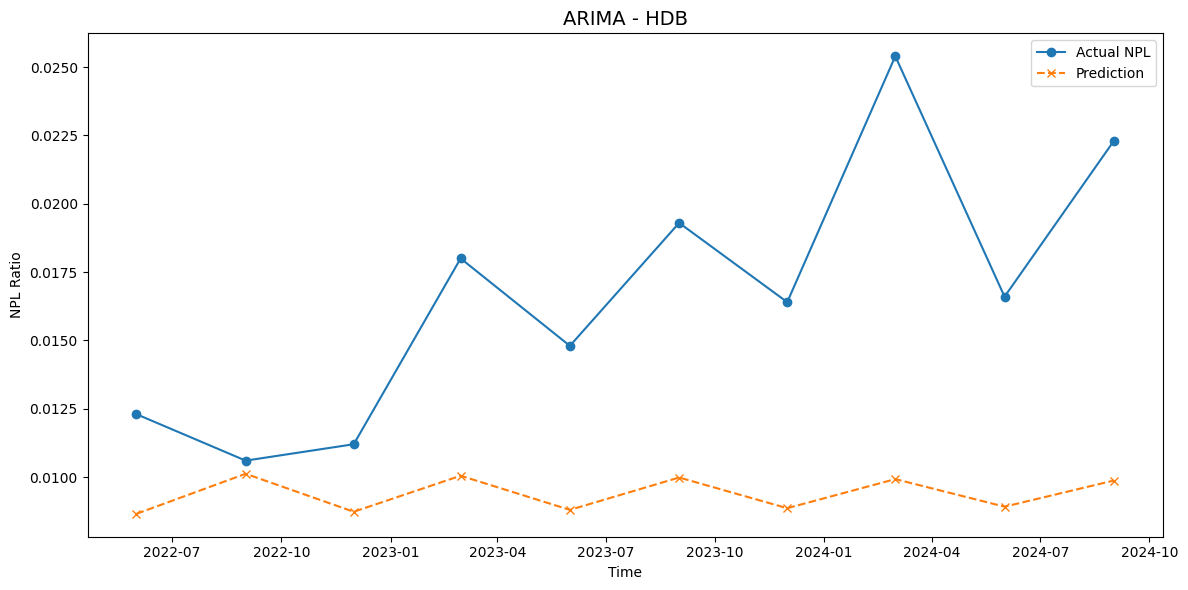


📈 Bank: ACB


c:\Downloads\[2025] Khóa luận\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
c:\Downloads\[2025] Khóa luận\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
c:\Downloads\[2025] Khóa luận\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


ARIMA - ACB | MAE: 0.0033, MSE: 0.0000, RMSE: 0.0040, R²: -1.2461, SMAPE: 31.26%, MASE: 2.3501


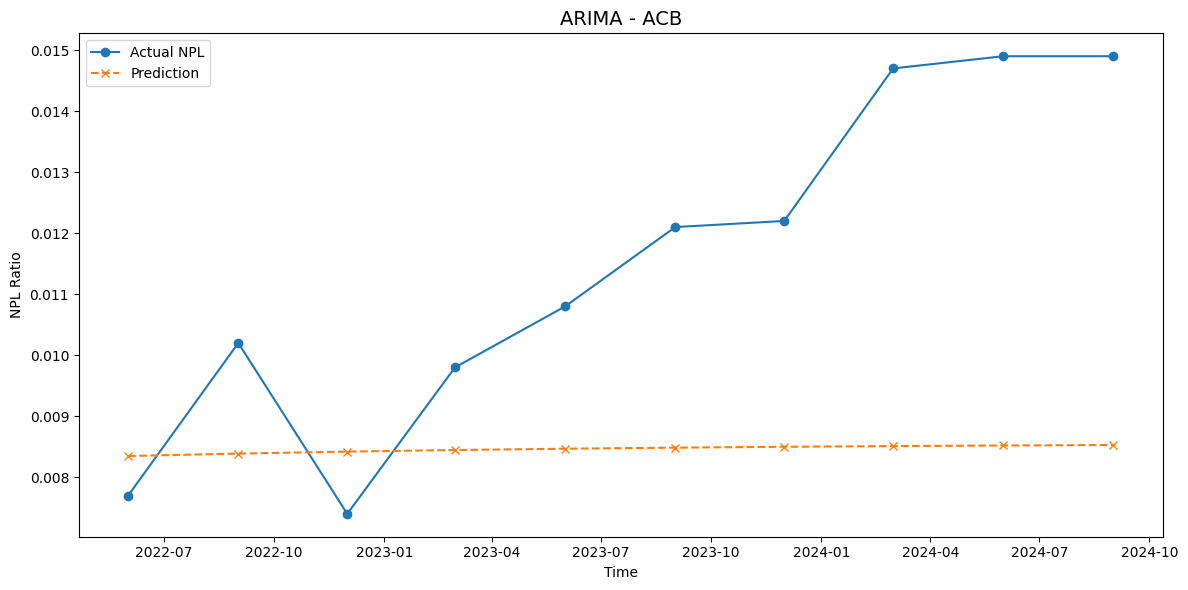


📈 Bank: MSB
ARIMA - MSB | MAE: 0.0053, MSE: 0.0000, RMSE: 0.0058, R²: 0.2092, SMAPE: 22.88%, MASE: 2.1778


c:\Downloads\[2025] Khóa luận\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
c:\Downloads\[2025] Khóa luận\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
c:\Downloads\[2025] Khóa luận\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


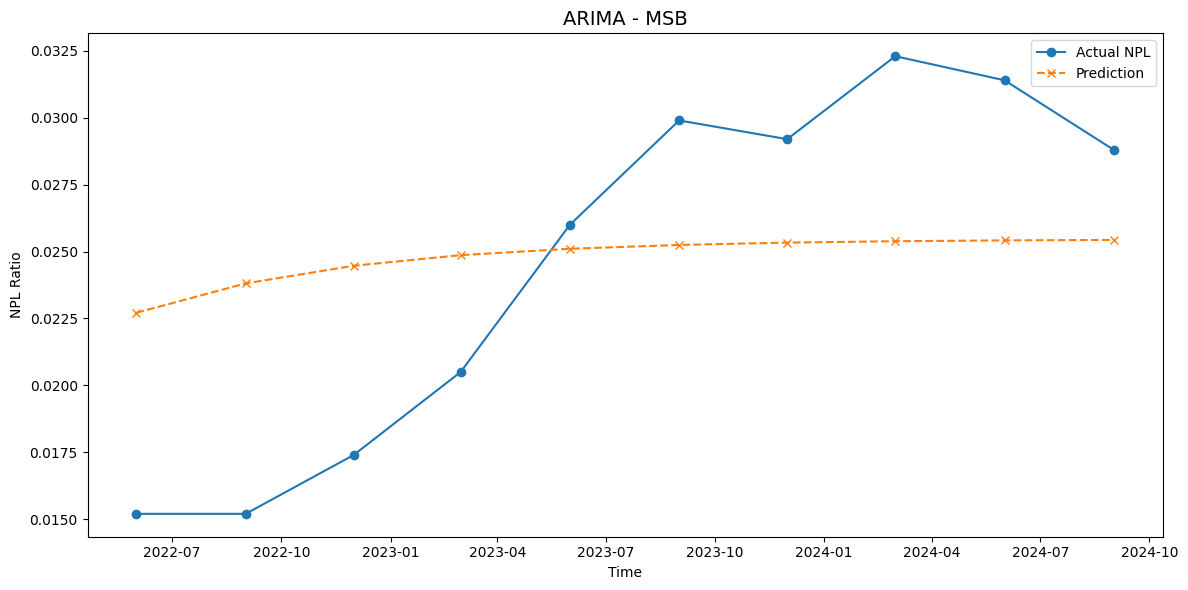

In [14]:
arima_models, arima_evals = run_arima_forecasting(train_df, test_df)

In [15]:
arima_results_df = pd.DataFrame(arima_evals, columns=["Bank", "Model", "MAE", "MSE", "RMSE", "R2", "SMAPE", "MASE"])
arima_results_df

,Bank,Model,MAE,MSE,RMSE,R2,SMAPE,MASE
0,ABB,ARIMA,0.010230,0.000154,0.012426,-2.078112,33.326644,1.595665
1,OCB,ARIMA,0.007887,0.000085,0.009213,-2.078421,29.493351,1.702120
2,SHB,ARIMA,0.001745,0.000005,0.002268,0.219543,6.325503,1.172216
3,VCB,ARIMA,0.003791,0.000022,0.004675,-3.209202,44.492122,2.420066
4,BID,ARIMA,0.004690,0.000026,0.005120,-5.213703,37.080922,2.411987
5,VPB,ARIMA,0.006351,0.000073,0.008538,-0.978118,11.498500,1.367454
6,MBB,ARIMA,0.003700,0.000019,0.004345,-1.122684,20.341616,1.493267
7,SSB,ARIMA,0.001674,0.000005,0.002127,-1.006683,9.420856,3.012364
8,BAB,ARIMA,0.004808,0.000030,0.005473,-1.977412,47.436029,3.253292
9,VIB,ARIMA,0.008922,0.000112,0.010572,-2.380126,29.515054,3.030061


In [16]:
top5= get_top_banks(arima_results_df, metric="MASE", top_n=5, model="ARIMA")

display(top5)

,Bank,Model,MAE,MSE,RMSE,R2,SMAPE,MASE
12,CTG,ARIMA,0.000931,0.000001,0.001208,-0.078508,6.808570,0.659516
17,KLB,ARIMA,0.002055,0.000006,0.002354,-0.367107,10.044876,0.876377
11,PGB,ARIMA,0.003647,0.000023,0.004827,-1.210989,12.851785,0.991656
2,SHB,ARIMA,0.001745,0.000005,0.002268,0.219543,6.325503,1.172216
16,NAB,ARIMA,0.006505,0.000053,0.007289,-0.792705,30.861503,1.295219


In [17]:
arima_results_df.to_excel("arima_results.xlsx", index=False)